In [2]:
# NOTE(liamvdv): todo: move to SSLConfig
# from gorillatracker.ssl_pipeline.ssl_config import SSLConfig

from sqlalchemy import select, text, create_engine
from sqlalchemy.orm import Session
from gorillatracker.ssl_pipeline.models import TrackingFrameFeature
from gorillatracker.ssl_pipeline.dataset import GorillaDatasetKISZ


sample = 10
query = text(
    f"""WITH ranked_features AS (
    SELECT
        tracking_id,
        tracking_frame_feature_id,
        bbox_width,
        bbox_height,
        frame_nr,
        feature_type,
        ROW_NUMBER() OVER (PARTITION BY tracking_id ORDER BY RANDOM()) AS rn
    FROM tracking_frame_feature
    WHERE feature_type = 'face_45'
        AND bbox_width >= 184
        AND bbox_height >= 184
        AND tracking_id IS NOT NULL
)
SELECT
    tracking_frame_feature_id
FROM ranked_features
WHERE rn <= {sample}
""")

# faster test query
# query = text(
#     """SELECT tracking_frame_feature_id
# FROM tracking_frame_feature
# WHERE feature_type = 'face_45' AND bbox_width >= 184 AND bbox_height >= 184 AND tracking_id IS NOT NULL LIMIT 10"""
# )


# engine = create_engine(GorillaDatasetKISZ.DB_URI)

# # stmt = select(TrackingFrameFeature).where(TrackingFrameFeature.tracking_frame_feature_id.in_(subquery))

# with Session(engine) as session:
#     result = session.execute(query).scalars().all()
#     for row in result:
#         print(row)

In [3]:
from pathlib import Path
from typing import List, Literal, Optional, Tuple

from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

import gorillatracker.type_helper as gtypes
from gorillatracker.transform_utils import SquarePad
from gorillatracker.type_helper import Id, Label
from gorillatracker.utils.labelencoder import LabelEncoder

# devcontainer.mount add "source=/mnt/vast-gorilla/cropped-images,target=/workspaces/gorillatracker/cropped-images,type=bind,ro"
base_path = "../cropped-images/2024-04-18"


def cast_label_to_int(labels: List[str]) -> List[int]:
    return LabelEncoder.encode_list(labels)


class HackDataset(Dataset[Tuple[Id, Tensor, Label]]):
    def get_tffs(self) -> list[TrackingFrameFeature]:
        engine = create_engine(GorillaDatasetKISZ.DB_URI)

        stmt = select(TrackingFrameFeature).where(TrackingFrameFeature.tracking_frame_feature_id.in_(query))

        with Session(engine) as session:
            return session.execute(stmt).scalars().all()

    def __init__(
        self, data_dir: str, partition: Literal["train", "val", "test"], transform: Optional[gtypes.Transform] = None
    ):
        self.ttfs = self.get_tffs()
        self.transform = transform
        self.partition = partition

    def __len__(self) -> int:
        return len(self.ttfs)

    def __getitem__(self, idx: int) -> Tuple[Id, Tensor, Label]:
        """tracklets will be labels for now"""
        ttf = self.ttfs[idx]

        img = Image.open(ttf.cache_path(base_path))
        if self.transform:
            img = self.transform(img)
        assert ttf.tracking_id is not None
        return ttf.tracking_frame_feature_id, img, ttf.tracking_id

    @classmethod
    def get_transforms(cls) -> gtypes.Transform:
        return transforms.Compose(
            [
                SquarePad(),
                # Uniform input, you may choose higher/lower sizes.
                transforms.Resize(224),
                transforms.ToTensor(),
            ]
        )

In [4]:
%load_ext autoreload
%autoreload 2

from gorillatracker.utils.embedding_generator import (
    get_run,
    get_model_from_run,
    generate_embeddings,
    read_embeddings_from_disk,
)
from torchvision import transforms

regen = False
file = "example.pkl"

if regen:
    run_url = "https://wandb.ai/gorillas/Embedding-SwinV2Large-CXL-Open/runs/bp5e1rnx/workspace?nw=nwuserliamvdv"
    run = get_run(run_url)
    model = get_model_from_run(run)
    dataset = HackDataset("", "val", transforms.Compose([HackDataset.get_transforms(), model.get_tensor_transforms()]))

In [5]:
%load_ext autoreload
%autoreload 2
import torch

torch.cuda.empty_cache()

if regen:
    model = get_model_from_run(run)
    df = generate_embeddings(model, dataset, device="cuda", batch_size=2600, worker=20)
    df["partition"] = "val"
    df.to_pickle(file)
else:
    df = read_embeddings_from_disk("example.pkl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: ylabel='Frequency'>

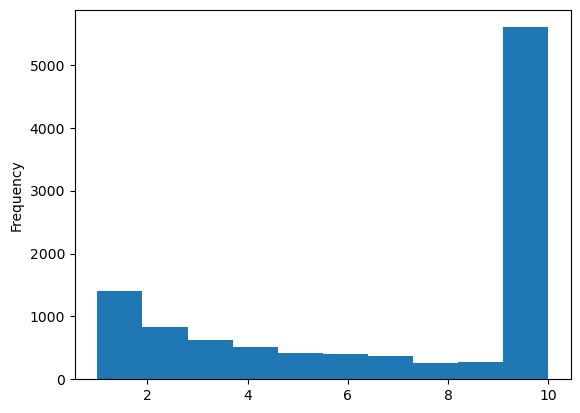

In [6]:
df["label"].value_counts().plot(kind="hist")

In [8]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract embeddings and labels
embeddings = np.vstack(df["embedding"].values)
labels = df["label"].values

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Define the range of k values to test
k_values = [5000, 10000]  # , 5000, 10000, 15000, 20000]

# random.seed(42)
# # downsample
# combined = list(zip(embeddings, labels))
# # Randomly sample elements
# random_sample = random.sample(combined, len(combined) // 10)
# # Separate the embeddings and labels
# sampled_embeddings, sampled_labels = zip(*random_sample)


# Initialize lists to store the evaluation metrics
silhouette_scores = []
davies_bouldin_scores = []

# Evaluate K-Means with different k values using k-means++ initialization
for k in k_values:
    print(f"Running K-Means++ with k={k}")
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(embeddings, labels)

    silhouette_avg = silhouette_score(embeddings, labels)
    davies_bouldin_avg = davies_bouldin_score(embeddings, labels)

    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot the evaluation metrics
fig, ax1 = plt.subplots()

color = "tab:blue"
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Silhouette Score", color=color)
ax1.plot(k_values, silhouette_scores, "o-", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Davies-Bouldin Score", color=color)
ax2.plot(k_values, davies_bouldin_scores, "s-", color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.title("Evaluation of K-Means Clustering with k-means++ Initialization")
plt.show()

# Find the optimal number of clusters
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
optimal_k_davies_bouldin = k_values[np.argmin(davies_bouldin_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k_silhouette}")
print(f"Optimal number of clusters based on Davies-Bouldin score: {optimal_k_davies_bouldin}")

Running K-Means++ with k=5000


KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Example data
X = embeddings 

ks = [2000, 3000, 4000, 5000, 6000, 7000, 10000, 15000, 20000]
for k in ks:
    # Create and fit the AgglomerativeClustering model on the reduced data
    agg_clustering = AgglomerativeClustering(n_clusters=1000, linkage="ward")
    agg_clustering.fit(X)

    # Get the cluster labels
    agg_labels = agg_clustering.labels_

    # Calculate silhouette score and Davies-Bouldin score
    sil_score = silhouette_score(X, agg_labels)
    db_score = davies_bouldin_score(X, agg_labels)

    # Print the scores
    print(f"Silhouette Score: {sil_score}")
    print(f"Davies-Bouldin Score: {db_score}")

    # Plot the PCA results
    plt.figure(figsize=(12, 6))

    # PCA scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], cmap="viridis")
    plt.title("PCA of the dataset")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label="Sample Index")

    # Plot the clustering results
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=agg_labels, cmap="viridis")
    plt.title("Agglomerative Clustering Results")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label="Cluster Label")

    plt.tight_layout()
    plt.show()